#Machine Learning: Random Forest

##CIFAR-10

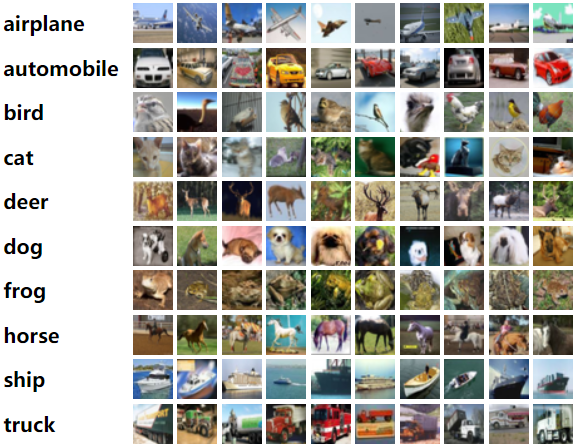

## Carregar pacotes e base de dados

In [1]:
# Pacotes que serão utilizados ao longo do script
import random
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage.feature import hog
from tensorflow.keras.datasets import cifar10
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, cohen_kappa_score, f1_score, confusion_matrix

# Configurando a semente
seed_value = 0

np.random.seed(seed_value)
random.seed(seed_value)
tf.random.set_seed(seed_value)

In [2]:
# Carregando a base de dados CIFAR-10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)
(50000, 1)
(10000, 1)


In [3]:
y_train[0:5]

array([[6],
       [9],
       [9],
       [4],
       [1]], dtype=uint8)

In [4]:
#                   0           1           2       3     4       5       6       7       8       9
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Função para mapear os labels numéricos para os nomes das classes
def map_labels_to_class_names(labels, class_names):
    return np.array([class_names[label[0]] for label in labels])

# Mapear os labels de treino e teste para os nomes das classes
y_train = map_labels_to_class_names(y_train, class_names)
y_test = map_labels_to_class_names(y_test, class_names)

In [5]:
y_train[0:5]

array(['frog', 'truck', 'truck', 'deer', 'automobile'], dtype='<U10')

In [6]:
import numpy as np

def select_classes(X, y, classes, num_samples):
    indices = []
    for cls in classes:
        cls_idx = np.where(y == cls)[0][:num_samples]
        indices.extend(cls_idx)
    return X[indices], y[indices]

# Definir classes e número de amostras por classe
classes_to_select = class_names[0:2]
num_samples_per_class = 5000

# Selecionar amostras para treino
X_train, y_train = select_classes(X_train, y_train, classes_to_select, num_samples_per_class)

# Selecionar amostras para teste
X_test, y_test = select_classes(X_test, y_test, classes_to_select, num_samples_per_class)

In [7]:
print(f'Train data shape: {X_train.shape}')
print(f'Test data shape: {X_test.shape}')
print(f'Train labels shape: {y_train.shape}')
print(f'Test labels shape: {y_test.shape}')

Train data shape: (10000, 32, 32, 3)
Test data shape: (2000, 32, 32, 3)
Train labels shape: (10000,)
Test labels shape: (2000,)


##Normalização

In [8]:
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

## Vetorização dos pixels

In [9]:
X_train_flat = X_train.reshape((X_train.shape[0], -1))
X_test_flat = X_test.reshape((X_test.shape[0], -1))

print(X_train_flat.shape)
print(X_test_flat.shape)

(10000, 3072)
(2000, 3072)


## Random Forest como classificador

In [10]:
# Treinamento de um modelo Random Forest
def train(X_train, y_train, n_estimators=100):
  model = RandomForestClassifier(n_estimators=n_estimators)
  model.fit(X_train, y_train.flatten())
  return model

In [11]:
# Inferência e avaliação
def predict_and_evaluate(model, X_test, y_test, normalize=None):

  # Inferência
  y_pred = model.predict(X_test)

  # Métricas
  print('Acurácia:', accuracy_score(y_test, y_pred))
  print('F1 score:', f1_score(y_test, y_pred, average='weighted'))

  # Matriz de confusão
  conf_matrix = confusion_matrix(y_test, y_pred, normalize=normalize)

  fmt = '.2f' if normalize == 'true' else 'd'
  sns.heatmap(conf_matrix, annot=True, fmt=fmt, cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
  plt.title('Matriz de Confusão')
  plt.xlabel('Predito')
  plt.ylabel('Verdadeiro')
  plt.show()

##Utilizar atributos extraídos da imagens ao invés do pixels e retreino

O Histogram of Oriented Gradients (HOG) é uma técnica para extração de features de imagens. Ela descreve a aparência e a forma local de um objeto dentro de uma imagem calculando a intensidade dos gradientes das bordas e a orientação dentro de regiões localizadas de uma imagem (capturando forma e estrutura de um objeto).

**Computacionalmente mais eficiente que uma rede extratora de atributos, como uma CNN, mas é invariante a mudanças de escala e rotação.

In [12]:
# Extração de características utilizando HOG
def extract_hog_features(images):
    hog_features = []
    for image in images:
        features = hog(image, orientations=9,      # o número de direções angulares distintas para as quais os gradientes são calculados
                       pixels_per_cell=(8, 8),   # tamanho (em pixels) de cada célula na qual a imagem é dividida para calcular o histograma de gradientes orientados
                       cells_per_block=(2, 2),   # número de células em cada bloco. Os blocos são usados para normalizar os histogramas de gradientes dentro de células, melhorando a robustez a variações de iluminação e contraste.
                       visualize=False,           # se a imagem HOG (uma representação visual das características HOG) deve ser retornada junto com o vetor de características.
                       channel_axis=-1)          # índice do eixo do canal na imagem de entrada.
        hog_features.append(features)
    return np.array(hog_features)

# Extraindo características HOG dos dados de treinamento e teste
X_train_hog = extract_hog_features(X_train)
X_test_hog = extract_hog_features(X_test)

In [13]:
# Atributos extraídos
X_train_hog.shape

(10000, 324)

Resultados de Teste
Acurácia: 0.9075
F1 score: 0.907498866861119


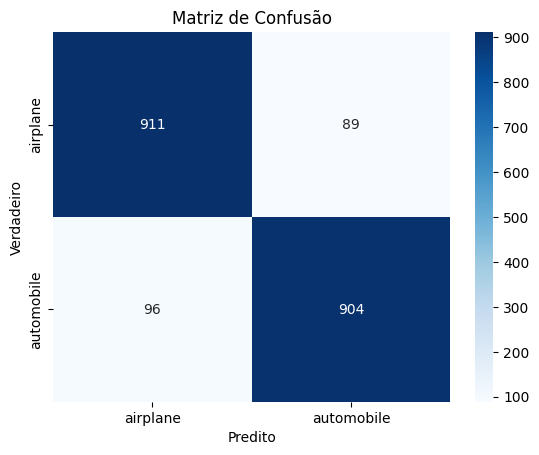

Resultados de Treino
Acurácia: 1.0
F1 score: 1.0


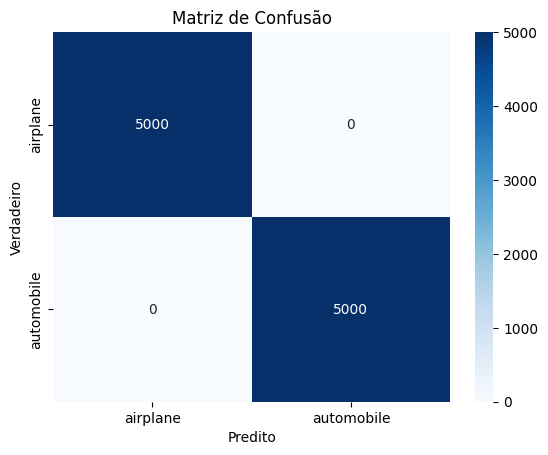

In [14]:
model = train(X_train_hog, y_train)

print('Resultados de Teste')
predict_and_evaluate(model, X_test_hog, y_test)
print('Resultados de Treino')
predict_and_evaluate(model, X_train_hog, y_train)

## Tuining de parâmetros utilizando Optuna (Otimização ao invés de força bruta)

In [15]:
!pip install optuna

In [16]:
import optuna

# Variáveis para armazenar o melhor modelo e a melhor métrica
best_model = None
best_accuracy = 0.0

def objective(trial):

    # Definir o espaço de busca para os hiperparâmetros
    n_estimators = trial.suggest_int('n_estimators', 10, 200)
    max_depth = trial.suggest_int('max_depth', 5, 40)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 30)

    # Cria modelo
    model = RandomForestClassifier(n_estimators=n_estimators,
                                   max_depth=max_depth,
                                   min_samples_leaf=min_samples_leaf,
                                   random_state=42)

    model.fit(X_train_hog, y_train)  # Treina
    y_pred = model.predict(X_test_hog)  # Infere
    accuracy = accuracy_score(y_test, y_pred)  # Calcula métrica

    # Atualize o melhor modelo se necessário
    global best_model, best_accuracy
    if accuracy > best_accuracy:
        best_model = model
        best_accuracy = accuracy

    return accuracy

# Cria estudo a ser otimizado
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Imprime a evolução dos modelos ao final da otimização
print(f'Melhor solução:')
trial = study.best_trial

print(f'Valor: {trial.value}')
print(f'Parâmetros: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')


[I 2024-07-17 13:10:19,473] A new study created in memory with name: no-name-2ff01caf-924b-4ce9-85aa-ca98de8ccdc2
[I 2024-07-17 13:11:03,388] Trial 0 finished with value: 0.893 and parameters: {'n_estimators': 171, 'max_depth': 17, 'min_samples_leaf': 17}. Best is trial 0 with value: 0.893.
[I 2024-07-17 13:11:15,366] Trial 1 finished with value: 0.887 and parameters: {'n_estimators': 80, 'max_depth': 14, 'min_samples_leaf': 19}. Best is trial 0 with value: 0.893.
[I 2024-07-17 13:11:26,967] Trial 2 finished with value: 0.8955 and parameters: {'n_estimators': 84, 'max_depth': 9, 'min_samples_leaf': 14}. Best is trial 2 with value: 0.8955.
[I 2024-07-17 13:11:29,736] Trial 3 finished with value: 0.8835 and parameters: {'n_estimators': 17, 'max_depth': 34, 'min_samples_leaf': 6}. Best is trial 2 with value: 0.8955.
[I 2024-07-17 13:11:45,121] Trial 4 finished with value: 0.902 and parameters: {'n_estimators': 95, 'max_depth': 14, 'min_samples_leaf': 8}. Best is trial 4 with value: 0.902.

Melhor solução:
Valor: 0.914
Parâmetros: 
    n_estimators: 167
    max_depth: 18
    min_samples_leaf: 3


 Optuna utiliza por padrão o algoritmo TPE (Tree-structured Parzen Estimator) para a otimização dos hiperparâmetros. Esse é um método de otimização bayesiana que constrói uma estimativa de probabilidade dos melhores valores de hiperparâmetros com base nas amostras já avaliadas.

 Existem outros otimizadores ou amostradores já implementados no pacote:

Samplers: https://optuna.readthedocs.io/en/stable/reference/samplers/index.html#module-optuna.samplers

 https://optuna.readthedocs.io/en/stable/reference/generated/optuna.create_study.html